# Mapping Digital Activism: Social Network Analysis of '#PeringatanDarurat' Movement on X (Twitter)

**Author:** Rafhiromadoni Sopandi | **Role:** Data Analyst
**Tech Stack:** Python, NetworkX, Pandas, Matplotlib

## 📌 Executive Summary
Proyek ini bertujuan untuk membedah pola penyebaran informasi terkait isu **#PeringatanDarurat** di platform X (Twitter). Menggunakan pendekatan *Graph Theory* dan *Social Network Analysis*, analisis ini mengidentifikasi:
1.  **Key Opinion Leaders (KOL):** Siapa aktor utama yang menggerakkan percakapan?
2.  **Information Flow:** Bagaimana narasi menyebar (apakah terpusat atau terdesentralisasi)?
3.  **Community Structure:** Apakah ada polarisasi atau komunitas yang terbentuk?

Hasil analisis ini berguna bagi *stakeholder* untuk memahami dinamika opini publik dan mendeteksi akun-akun berpengaruh (influencer/buzzer) secara algoritmik, bukan sekadar jumlah followers.

## 1. Data Preparation & Network Construction
Data diambil dari percakapan Twitter yang mengandung tagar terkait. Node (titik) merepresentasikan **User**, dan Edge (garis) merepresentasikan interaksi (**Retweet, Reply, Quote**).

Tujuan tahap ini adalah membersihkan data mentah menjadi format *Edgelist* (Source -> Target) yang siap diolah menjadi graf.

## Persiapan Modul

In [4]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from collections import deque

## Deskripsi Pengumpulan Data

**Penjelasan Atribut**:
1. conversation_id_str: ID unik dari percakapan yang terkait dengan tweet, dalam bentuk string. Jika tweet merupakan tweet awal dari percakapan, maka atribut ini akan sama dengan id_str. Jika tweet merupakan balasan atau kutipan dari tweet lain, maka atribut ini akan mengacu pada id_str dari tweet awal.
2. created_at: Tanggal dan waktu ketika tweet dibuat, dalam format UTC (Universal Time Coordinated).
3. favorite_count: Jumlah favorit atau suka yang diberikan oleh pengguna lain terhadap tweet ini, dalam bentuk angka.
4. full_text: Teks lengkap dari tweet, termasuk hashtag, mention, dan emoji.
5. id_str: ID unik dari tweet, dalam bentuk string.
6. image_url: URL atau tautan dari gambar yang ada pada suatu tweet. Jika tweet tidak ada gambar, nilai atribut ini adalah none.
7. in_reply_to_screen_name: Nama pengguna yang tweet-nya di-reply.
8. lang: Kode bahasa yang digunakan dalam tweet, sesuai dengan standar ISO 639-1.
9. location: Lokasi saat tweet dibuat.
10. quote_count: Jumlah tweet yang mengutip tweet ini, dalam bentuk angka.
11. reply_count: Jumlah balasan yang diterima tweet ini, dalam bentuk angka.
12. retweet_count: Jumlah retweet yang dilakukan oleh pengguna lain terhadap tweet ini, dalam bentuk angka.
13. tweet_url: URL atau tautan dari tweet, dalam bentuk string. URL ini dapat digunakan untuk mengakses tweet secara langsung di situs web atau aplikasi Twitter.
14. user_id_str: ID unik dari pengguna yang membuat tweet, dalam bentuk string.
15. username: Nama pengguna atau handle dari pengguna yang membuat tweet, dalam bentuk string.

**Kriteria Crawling:**
1. Crawling dilakukan berdasarkan hashtag #PeringatanDarurat
2. Crawling dilakukan dengan format sejak tanggal 21 Agustus 2024, yaitu saat hashtag ini pertama kali muncul dan trending
3. Crawling dilakukan dengan jumlah kurang lebih 5000 tweet

Crawling data dilakukan menggunakan tweet harvest, sebuah modul node.js yang dapat mengambil data twitter sesuai dengan parameter yang ditentukan. Tweet harvest dijalankan di Google Colab untuk crawling (setelah menginstall node.js).

Crawling dilakukan dengan keyword hashtag #PeringatanDarurat, dengan jumlah tweet kurang lebih 5000, dan dengan format sejak tanggal 21 Agustus 2024. Hasil crawling disimpan dalam file csv dengan nama PeringatanDarurat.csv. Berikut adalah kode yang kami gunakan untuk melakukan scrapping.

**Dataset:**
- Dataset hasil crawling yang telah dilakukan dapat dilihat atau diunduh [disini](https://1drv.ms/x/c/f4a317f49e2647da/EUwrosz_ih1NshKrNSD1RrMB-yi3JjBsyeZzJ_l7dRyQ1A?e=ynYRrD)

## Persiapan Data

In [5]:
url = 'https://raw.githubusercontent.com/bitabayu/Dataset/main/PeringatanDaruratv2.csv'
dataset = pd.read_csv(url, delimiter=',', on_bad_lines='skip')
dataset.head()

conversation_id_str                      created_at  favorite_count  \
0         1.826410e+18  Wed Aug 21 23:59:49 +0000 2024               0   
1         1.826410e+18  Wed Aug 21 23:59:30 +0000 2024               1   
2         1.826410e+18  Wed Aug 21 23:58:28 +0000 2024           14634   
3         1.826410e+18  Wed Aug 21 23:58:24 +0000 2024               0   
4         1.826410e+18  Wed Aug 21 23:52:44 +0000 2024               0   

                                           full_text        id_str  \
0  good luck and please STAY SAFE everyone! may G...  1.826410e+18   
1  #saveindonesia #PeringatanDarurat #bangkitkank...  1.826410e+18   
2  the government has been taken over by an entit...  1.826410e+18   
3  Buat siapapun yang ikut aksi perjuangan hari i...  1.826410e+18   
4  Such a lavish life style you have there @kaesa...  1.826410e+18   

                                         image_url in_reply_to_screen_name  \
0                                              NaN                     NaN   
1  https://pbs.twimg.com/media/GVi1I3kWYAAZjd2.jpg                     NaN   
2  https://pbs.twimg.com/media/GVi05Z5aUAAkDde.jpg                     NaN   
3                                              NaN                     NaN   
4                                              NaN                     NaN   

  lang       location  quote_count  reply_count  retweet_count  \
0   en  rps-rant🔞🏳️‍🌈            0            0              0   
1  qme            NaN            0            0              0   
2   en            NaN          114           88           5430   
3   in          EARTH            0            0              0   
4   en            NaN            0            0              0   

                                           tweet_url   user_id_str  \
0  https://x.com/ssunchldd/status/182640890012155...  8.640960e+17   
1  https://x.com/DullahFirman/status/182640882113...  1.552180e+18   
2  https://x.com/zetyadesu/status/182640855846608...  1.340900e+18   
3  https://x.com/madsyafari/status/18264085435512...  7.271730e+17   
4  https://x.com/uberfunk/status/1826407115944329595  2.917459e+07   

       username  
0     ssunchldd  
1  DullahFirman  
2     zetyadesu  
3    madsyafari  
4      uberfunk

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5366 entries, 0 to 5365
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      5366 non-null   float64
 1   created_at               5366 non-null   object 
 2   favorite_count           5366 non-null   int64  
 3   full_text                5366 non-null   object 
 4   id_str                   5366 non-null   float64
 5   image_url                620 non-null    object 
 6   in_reply_to_screen_name  3706 non-null   object 
 7   lang                     5366 non-null   object 
 8   location                 2843 non-null   object 
 9   quote_count              5366 non-null   int64  
 10  reply_count              5366 non-null   int64  
 11  retweet_count            5366 non-null   int64  
 12  tweet_url                5366 non-null   object 
 13  user_id_str              5366 non-null   float64
 14  username                

Data yang di ambil adalah data sejak tanggal 21 Agustus 2024 dengan jumlah tweet sebanyak kurang lebih 5000 tweet.

In [7]:
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset['created_at'].dt.date.unique()

/tmp/ipython-input-717344741.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['created_at'] = pd.to_datetime(dataset['created_at'])


array([datetime.date(2024, 8, 21), datetime.date(2024, 8, 22),
       datetime.date(2024, 8, 23), datetime.date(2024, 8, 24)],
      dtype=object)

Selanjutnya menurunkan atribut "total_interaction" yang dihitung sebagai hasil penjumlahan dari empat atribut lainnya, yaitu "retweet_count", "favorite_count", "quote_count", dan "reply_count". Ini digunakan untuk mencerminkan sejauh mana suatu tweet memiliki dampak atau interaksi dengan pengguna lain dalam konteks media sosial seperti Twitter.

In [8]:
dataset['total_interaction'] = dataset['retweet_count'] + dataset['favorite_count'] + dataset['quote_count'] + dataset['reply_count']
dataset.sort_values(by='total_interaction', ascending=False, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5366 entries, 2315 to 2011
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   conversation_id_str      5366 non-null   float64            
 1   created_at               5366 non-null   datetime64[ns, UTC]
 2   favorite_count           5366 non-null   int64              
 3   full_text                5366 non-null   object             
 4   id_str                   5366 non-null   float64            
 5   image_url                620 non-null    object             
 6   in_reply_to_screen_name  3706 non-null   object             
 7   lang                     5366 non-null   object             
 8   location                 2843 non-null   object             
 9   quote_count              5366 non-null   int64              
 10  reply_count              5366 non-null   int64              
 11  retweet_count            5366 no

## Analisis Data

In [9]:
print("Unique tweets: {}".format(len(dataset['full_text'].unique())))
print("All tweets: {}".format(len(dataset['full_text'])))

Unique tweets: 3932
All tweets: 5366


Output diatas menunjukkan tweet yang unik ada sebanyak 3932 dari total 5366 tweets, yang artinya, kemungkinan sisanya adalah retweet atau tweet yang sama yang diunggah oleh user lain.

In [10]:
# retweets = []
actual_tweets = []
for i in zip(dataset['username'], dataset['full_text'], dataset['total_interaction']):
    if re.search(r'^\bRT\b', i[1]) == None:
        actual_tweets.append([i[0], i[1], i[2]])
    # else:
    #     retweets.append([i[0], i[1], i[2]])

actual_tweets = np.array(actual_tweets)
# retweets = np.array(retweets)

print("Unique tweets: {}".format(len(actual_tweets)))
# print("Retweets: {}".format(len(retweets)))

Unique tweets: 5366


Terlihat bahwa terdapat 5366 tweets atau semua tweet adalah tweet unik.

In [11]:
# Penggabungan kembali Actual Tweets dan Retweets
# original_tweets = np.concatenate((actual_tweets, retweets), axis=0)
original_tweets = actual_tweets
original_tweets = pd.DataFrame(original_tweets, columns=['username', 'full_text', 'total_interaction'])
original_tweets['total_interaction'] = original_tweets['total_interaction'].astype(np.int64)
original_tweets.sort_values(by='total_interaction', ascending=False, inplace=True)
original_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5366 entries, 0 to 2366
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   username           5366 non-null   object
 1   full_text          5366 non-null   object
 2   total_interaction  5366 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 167.7+ KB


In [12]:
original_tweets['total_interaction'].sort_values(ascending=False).unique()

array([50824, 50038, 47406, 20266, 14976, 10368,  9041,  6383,  5944,
        5041,  4926,  4034,  2620,   938,   866,   842,   651,   639,
         554,   456,   448,   446,   429,   415,   414,   347,   289,
         173,   167,   149,   144,   121,   118,   116,   111,    81,
          77,    71,    66,    60,    56,    51,    50,    45,    42,
          38,    37,    35,    34,    33,    30,    28,    23,    22,
          21,    19,    18,    17,    16,    15,    14,    13,    12,
          11,    10,     9,     8,     7,     6,     5,     4,     3,
           2,     1,     0])

Selanjutnya, akan di buat kode untuk mencari dan mengelompokkan user yang di sebutkan dalam teks tweet, berdasarkan apakah mereka termasuk dalam dataset username atau tidak.
- **in_set:** Hubungan yang disebutkan dalam tweet dan ada dalam dataset username, yang berarti pengguna yang disebutkan adalah pengguna yang ada dalam dataset.

In [13]:
in_set = []

for user in original_tweets.values:
    mentioned = re.findall(r'@\w*', user[1])
    if mentioned != []:
        for user_mentioned in mentioned:
            if (user_mentioned[1:] in dataset['username'].unique()) and (user[0] != user_mentioned[1:]):
                in_set.append([user[0], user_mentioned[1:], user[2]])

print(len(in_set))

171


In [14]:
inset = pd.DataFrame(in_set, columns=['user', 'mentioned', 'total_interaction'])
inset['total_interaction'] = inset['total_interaction'].astype(np.int64)
inset.sort_values(by='total_interaction', ascending=False, inplace=True)
inset.head()

user      mentioned  total_interaction
0  kun_fayakun212     tempodotco                  8
1        Ars_sand   berlianidris                  4
2     cassiop3144        L120079                  3
3  kun_fayakun212  RadioElshinta                  3
4  SetyoKuncoro10   stepupreneur                  3

In [15]:
# Explode kolom mention
inset = inset.explode('mentioned').reset_index(drop=True)
inset.head()

user      mentioned  total_interaction
0  kun_fayakun212     tempodotco                  8
1        Ars_sand   berlianidris                  4
2     cassiop3144        L120079                  3
3  kun_fayakun212  RadioElshinta                  3
4  SetyoKuncoro10   stepupreneur                  3

In [16]:
# Meengoutputkan nilai max dan min dari total_interaction
max_total_interaction = max(inset['total_interaction'])
min_total_interaction = min(inset['total_interaction'])

print("Max total_interaction: {}".format(max_total_interaction))
print("Min total_interaction: {}".format(min_total_interaction))

Max total_interaction: 8
Min total_interaction: 0


In [17]:
# Menghapus @ pada kolom mention
inset['mentioned'] = inset['mentioned'].apply(lambda x: x.lstrip('@'))
inset.head()

user      mentioned  total_interaction
0  kun_fayakun212     tempodotco                  8
1        Ars_sand   berlianidris                  4
2     cassiop3144        L120079                  3
3  kun_fayakun212  RadioElshinta                  3
4  SetyoKuncoro10   stepupreneur                  3

In [18]:
# Mengambil 5 teratas berdasarkan value_counts dari kolom 'user' dan 'mention'
print(inset['user'].value_counts()[:5])
print()
print(inset['mentioned'].value_counts()[:5])

user
quansahie     5
weolluna      5
caffeinnvn    5
aecocoo       3
jjhyuunn      3
Name: count, dtype: int64

mentioned
iiksanboy         16
tempodotco        11
uapairdilangit    10
kompascom          8
ournyssa           7
Name: count, dtype: int64


## Visualisasi Data

## 2. Network Visualization
Visualisasi berikut merepresentasikan topologi jaringan percakapan. Ukuran Node disesuaikan berdasarkan jumlah koneksi (Degree), di mana node yang lebih besar menunjukkan aktor yang lebih aktif/populer.

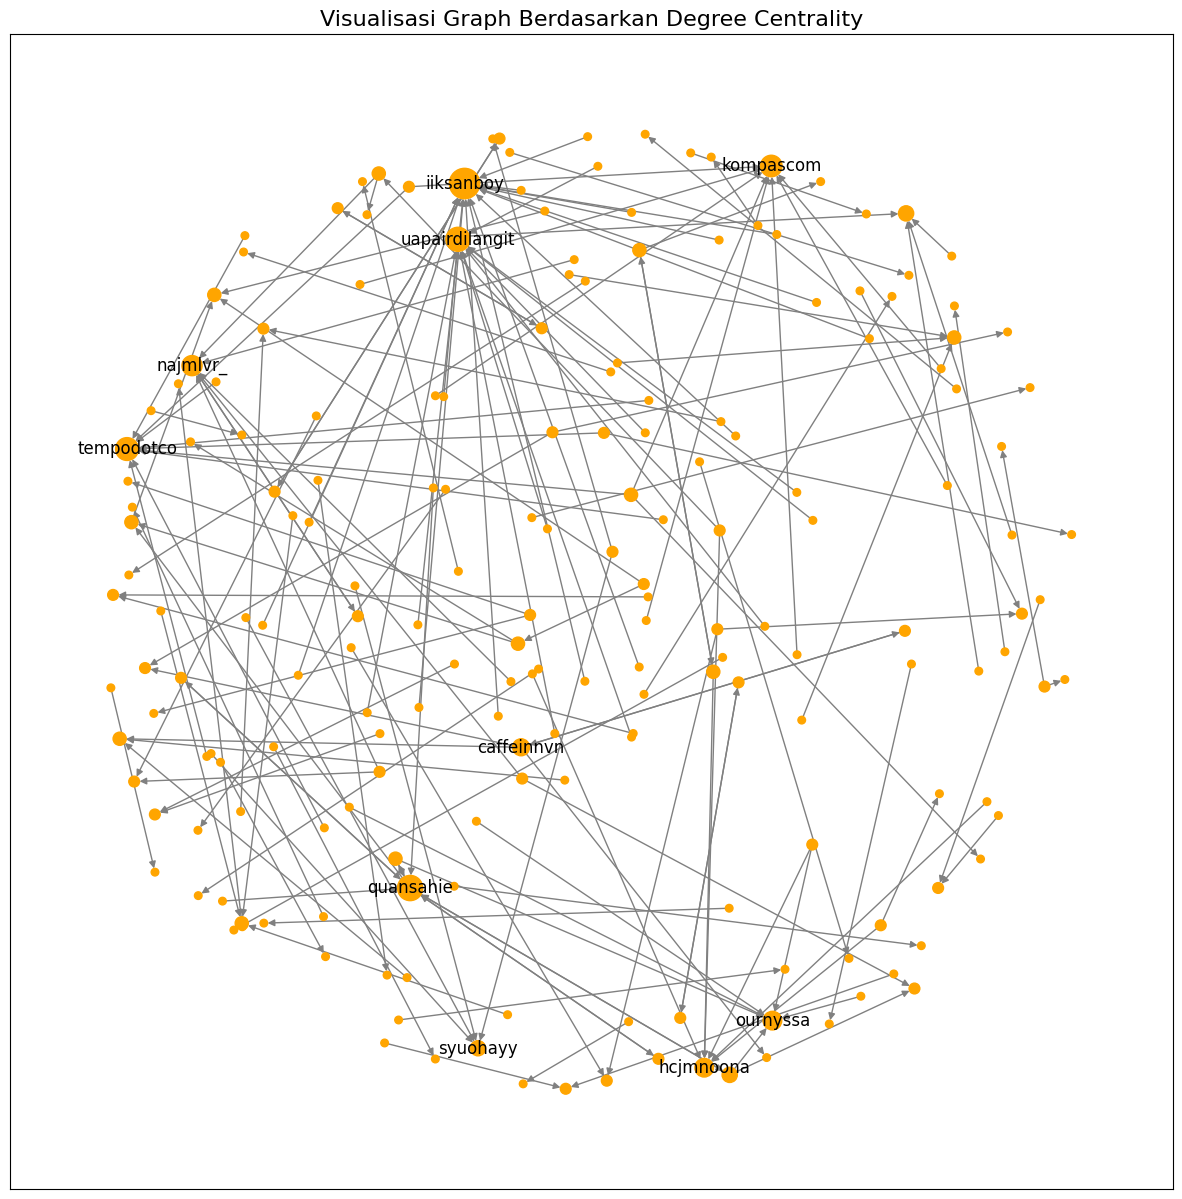

In [19]:
# Membuat visualisasi graph menggunakan metode fruchterman reingold
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

degree_centrality = dict(G.degree())
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

plt.figure(figsize=(15, 15))
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)
nx.draw_networkx(G,
                 with_labels=True,
                 labels={node: node if node in top_nodes else "" for node in G.nodes()},
                 node_color='orange',
                 edge_color='grey',
                 linewidths=1,
                 font_size=12,
                 node_size=[v * 30 for v in dict(G.degree()).values()],
                 pos=pos
                 )
plt.title("Visualisasi Graph Berdasarkan Degree Centrality", fontsize=16)
plt.show()

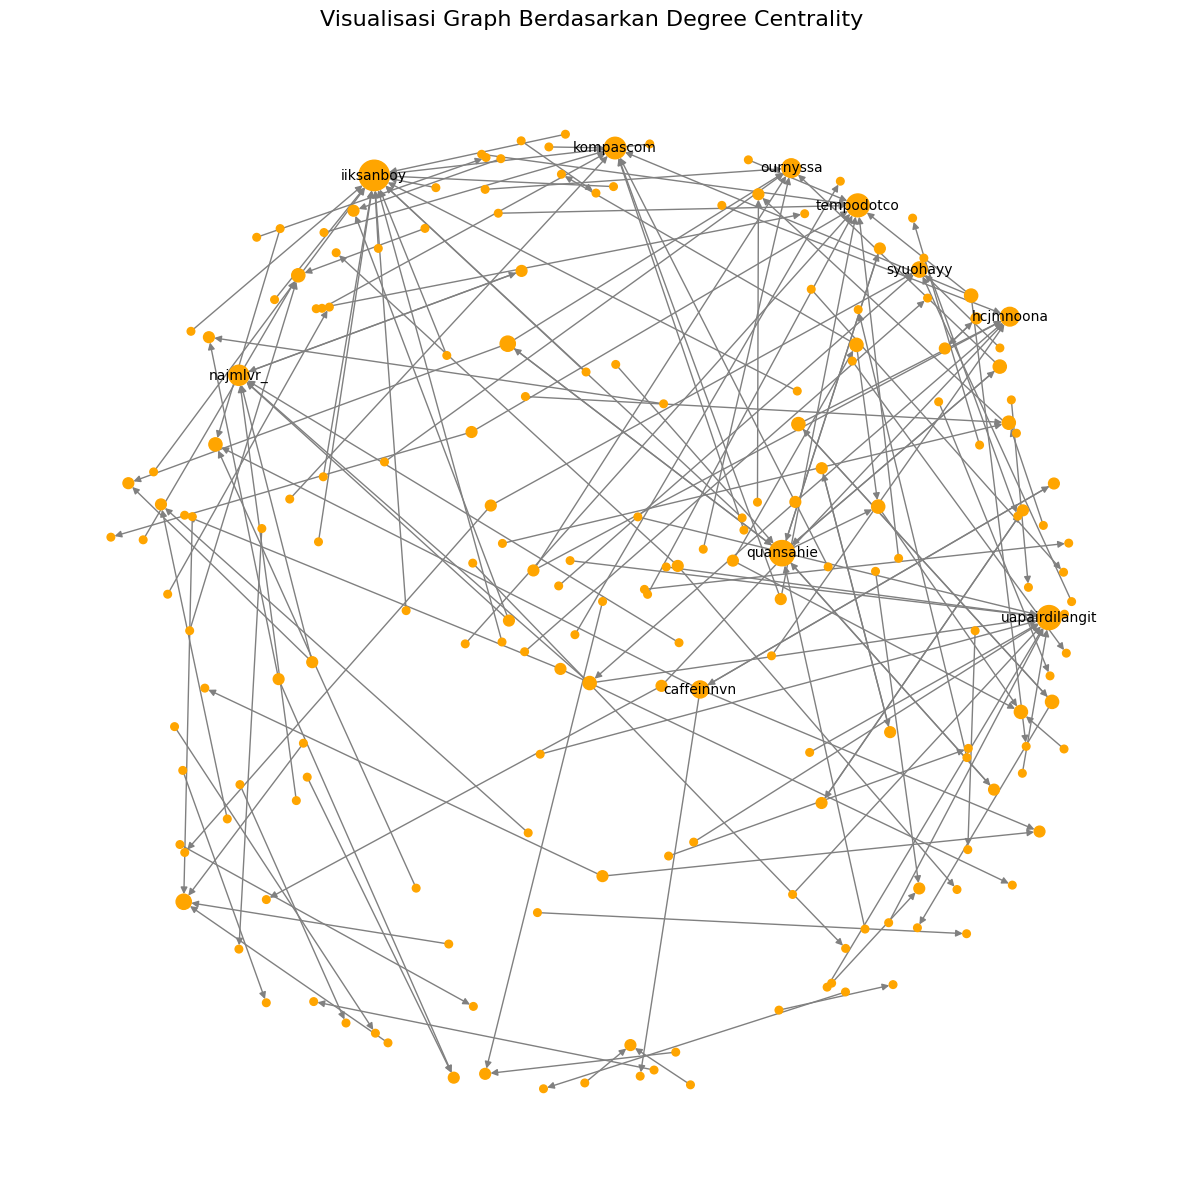

In [20]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Hitung Degree Centrality (gunakan degree total = in + out)
degree_centrality = dict(G.degree())

# Ambil top 10 node dengan degree terbesar
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

# Ukuran node berdasarkan degree centrality
node_sizes = [degree_centrality[n] * 30 for n in G.nodes()]

# Posisi node menggunakan Fruchterman-Reingold layout
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Visualisasi graph
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='orange',
    edge_color='gray',
    linewidths=1,
    font_size=10,
    node_size=node_sizes
)

plt.title("Visualisasi Graph Berdasarkan Degree Centrality", fontsize=16)
plt.axis("off")
plt.show()

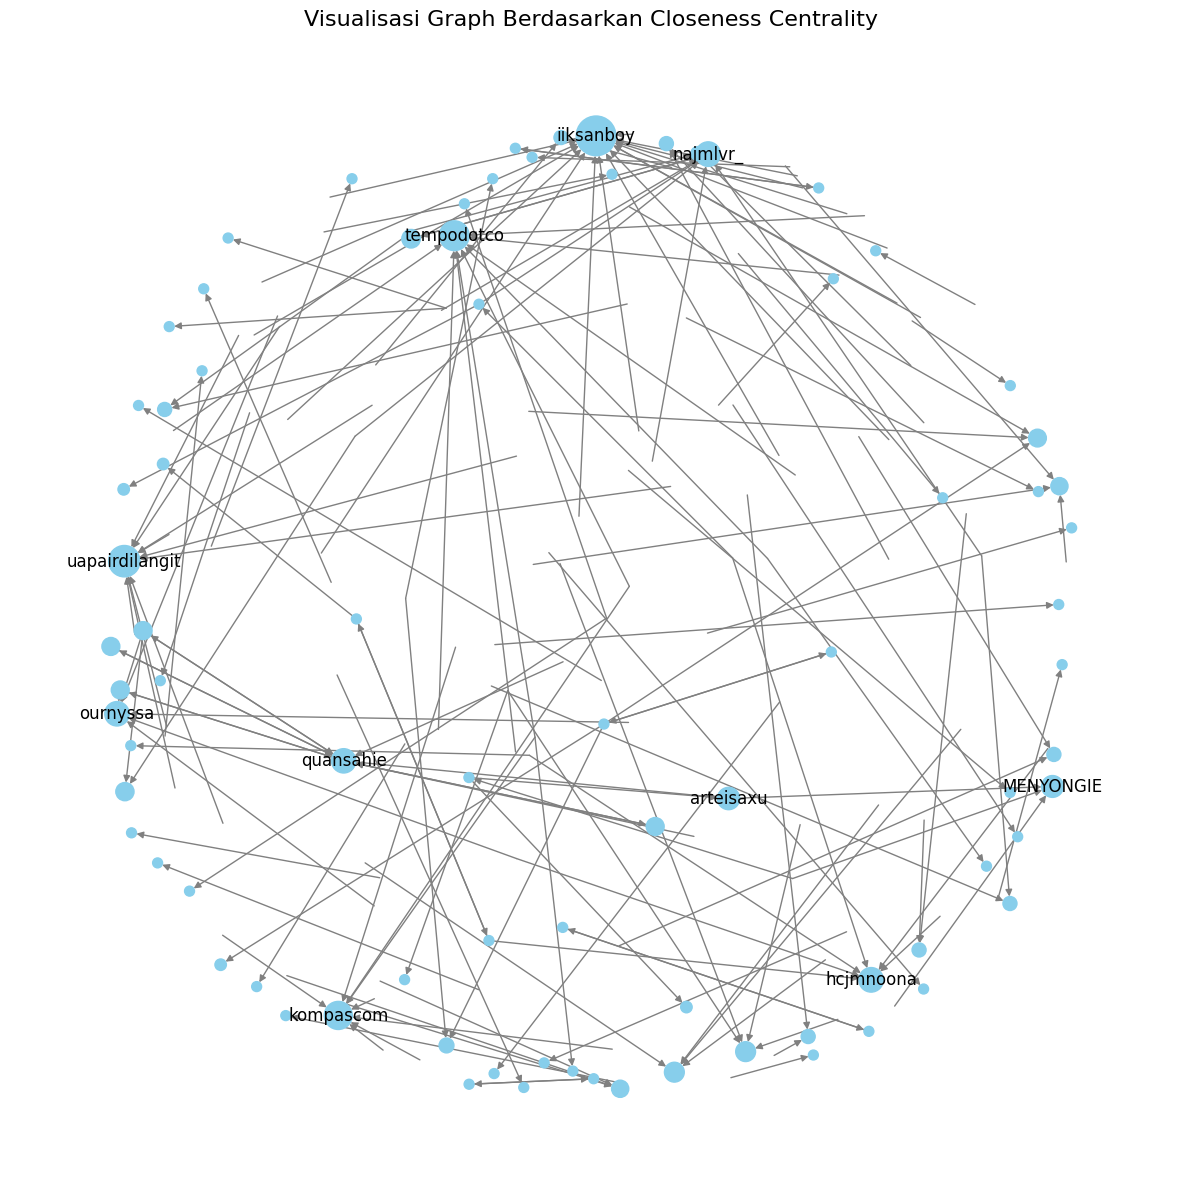

In [21]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Hitung closeness centrality
closeness = nx.closeness_centrality(G)

# Ambil top 10 pengguna berdasarkan closeness centrality
top_nodes = sorted(closeness, key=closeness.get, reverse=True)[:10]

# Atur ukuran node berdasarkan closeness centrality
node_sizes = [closeness[n] * 10000 for n in G.nodes()]

# Buat posisi layout
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Buat figure
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='skyblue',
    edge_color='gray',
    linewidths=1,
    font_size=12,
    node_size=node_sizes
)
plt.title("Visualisasi Graph Berdasarkan Closeness Centrality", fontsize=16)
plt.axis("off")
plt.show()

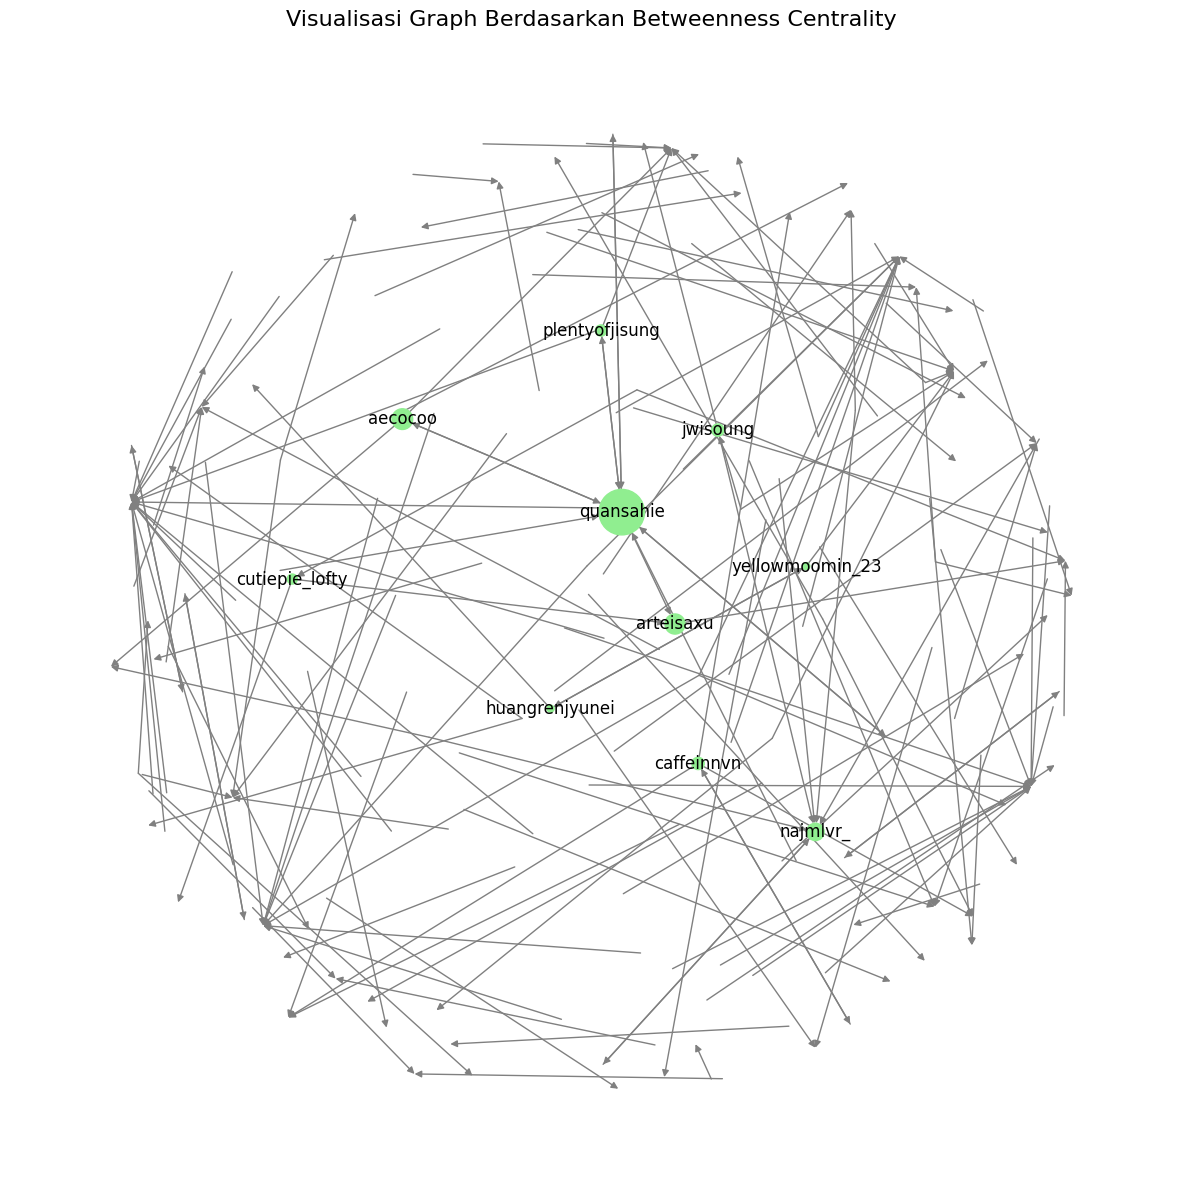

In [22]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Hitung Betweenness Centrality
betweenness = nx.betweenness_centrality(G)

# Ambil top 10 pengguna dengan nilai betweenness tertinggi
top_nodes = sorted(betweenness, key=betweenness.get, reverse=True)[:10]

# Ukuran node berdasarkan nilai betweenness
node_sizes = [betweenness[n] * 1000000 for n in G.nodes()]

# Layout Fruchterman-Reingold
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Visualisasi graph
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='lightgreen',
    edge_color='gray',
    linewidths=1,
    font_size=12,
    node_size=node_sizes
)
plt.title("Visualisasi Graph Berdasarkan Betweenness Centrality", fontsize=16)
plt.axis("off")
plt.show()

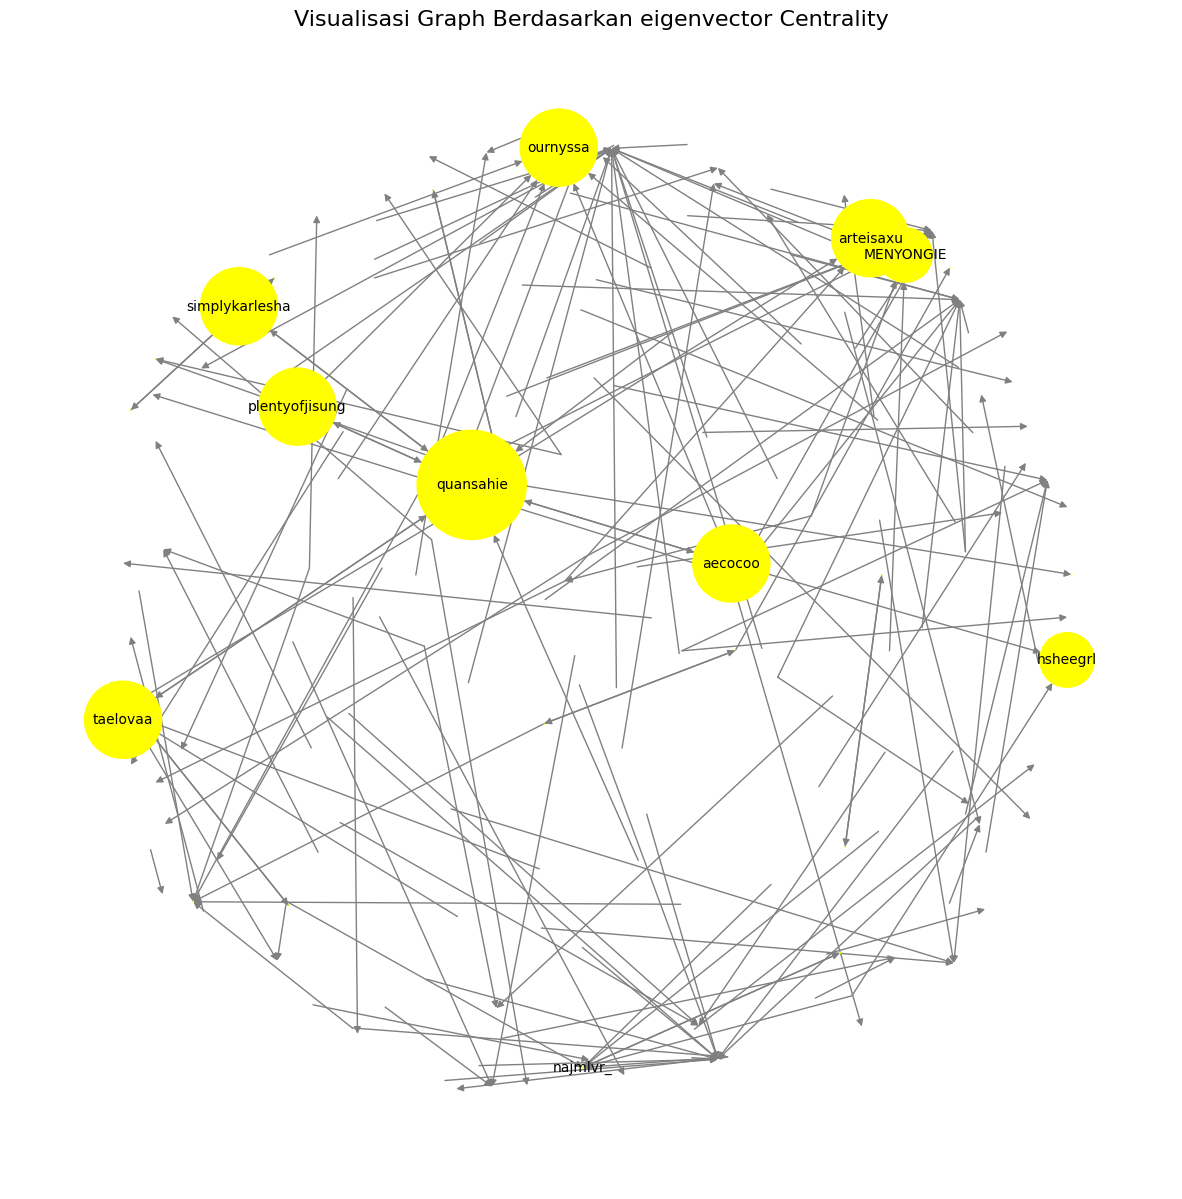

In [23]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Calculate eigenvector Centrality and store the result in a variable
eigen_centrality_values = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

# Ambil 10 node teratas
top_nodes = sorted(eigen_centrality_values, key=eigen_centrality_values.get, reverse=True)[:10]

# Ukuran node berdasarkan nilai eigenvector Centrality
node_sizes = [eigen_centrality_values[n] * 10000 for n in G.nodes()]

# Posisi node dengan layout Fruchterman-Reingold
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Visualisasi
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='yellow',
    edge_color='gray',
    linewidths=1,
    font_size=10,
    node_size=node_sizes
)

plt.title("Visualisasi Graph Berdasarkan eigenvector Centrality", fontsize=16)
plt.axis("off")
plt.show()

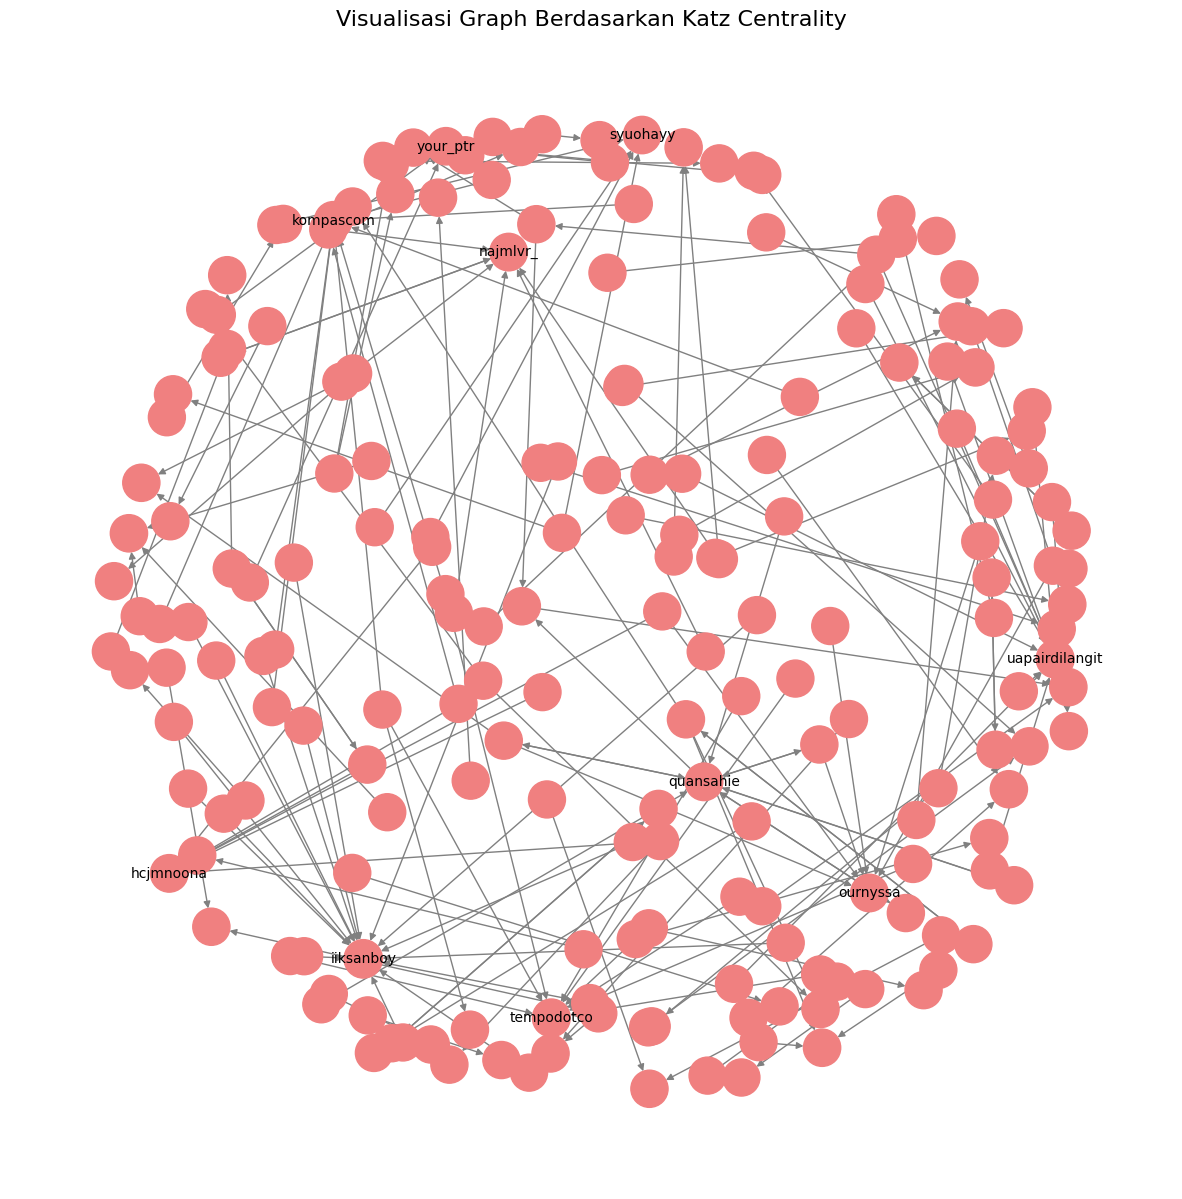

In [24]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Hitung Katz Centrality
katz_centrality = nx.katz_centrality(G, alpha=0.005, beta=1.0, max_iter=1000, tol=1e-06)

# Ambil 10 node teratas
top_nodes = sorted(katz_centrality, key=katz_centrality.get, reverse=True)[:10]

# Ukuran node berdasarkan nilai Katz Centrality
node_sizes = [katz_centrality[n] * 10000 for n in G.nodes()]

# Posisi node dengan layout Fruchterman-Reingold
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Visualisasi
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='lightcoral',
    edge_color='gray',
    linewidths=1,
    font_size=10,
    node_size=node_sizes
)

plt.title("Visualisasi Graph Berdasarkan Katz Centrality", fontsize=16)
plt.axis("off")
plt.show()

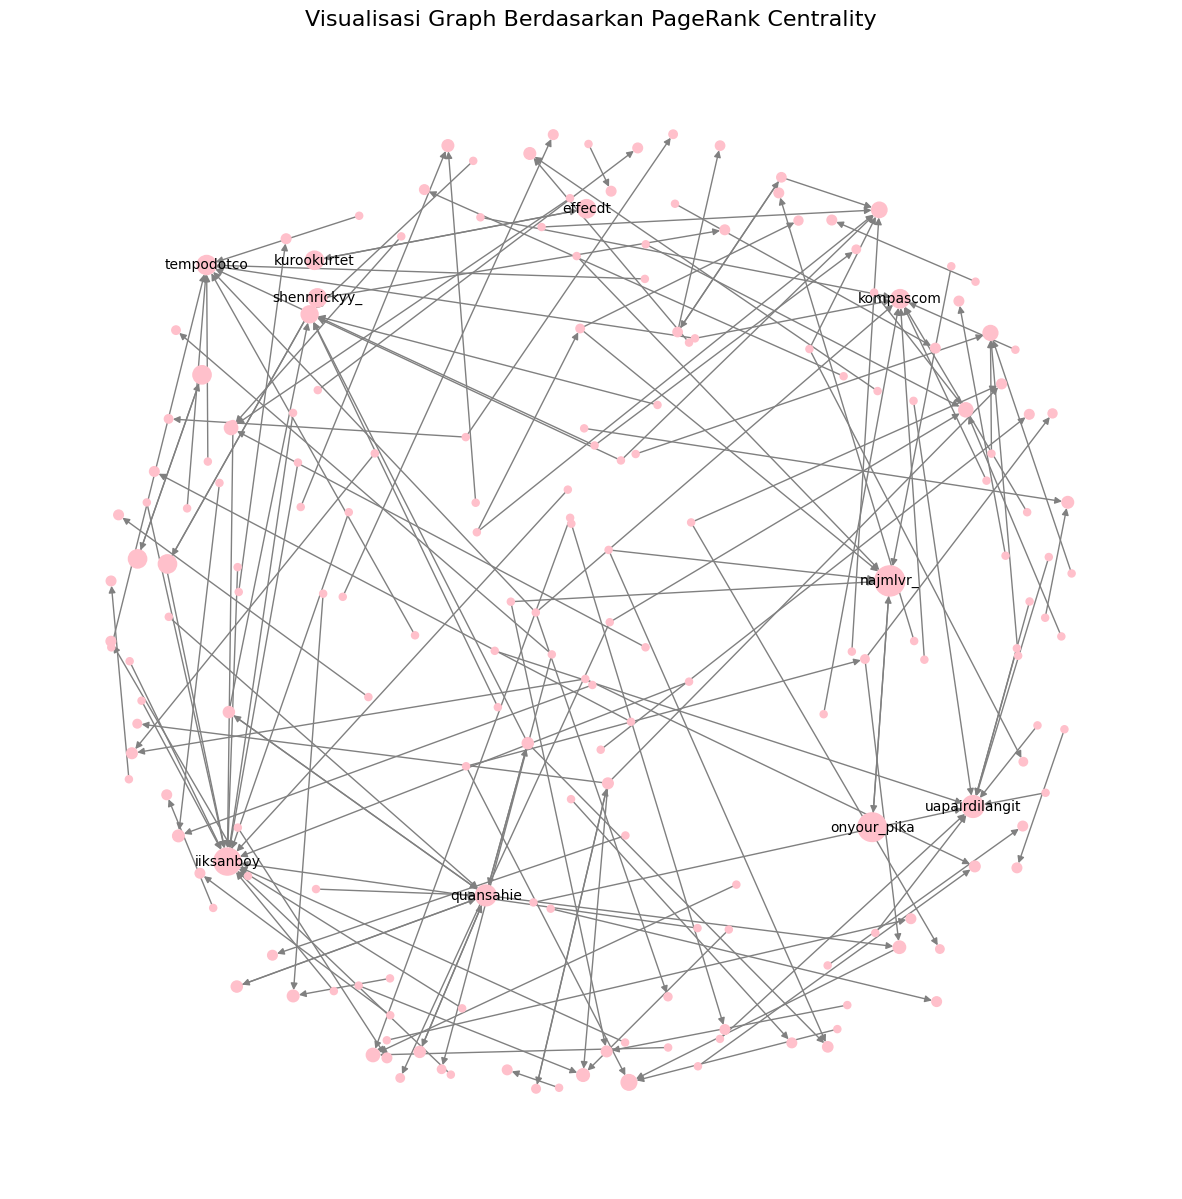

In [25]:
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

# Hitung PageRank Centrality
pagerank_centrality = nx.pagerank(G, alpha=0.85)

# Ambil 10 node dengan PageRank tertinggi
top_nodes = sorted(pagerank_centrality, key=pagerank_centrality.get, reverse=True)[:10]

# Ukuran node berdasarkan nilai PageRank
node_sizes = [pagerank_centrality[n] * 10000 for n in G.nodes()]

# Posisi node menggunakan layout Fruchterman-Reingold
pos = nx.fruchterman_reingold_layout(G, k=0.5, iterations=50)

# Visualisasi graph
plt.figure(figsize=(15, 15))
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    labels={node: node if node in top_nodes else "" for node in G.nodes()},
    node_color='pink',
    edge_color='gray',
    linewidths=1,
    font_size=10,
    node_size=node_sizes
)

plt.title("Visualisasi Graph Berdasarkan PageRank Centrality", fontsize=16)
plt.axis("off")
plt.show()

Gambar diatas merupakan hasil visualisasi graph menggunakan metode fruchterman reingold. Metode Fruchterman-Reingold adalah salah satu algoritma yang digunakan untuk visualisasi graf. Algoritma ini menggambar graf dengan menggunakan gaya tarik dan tolak antara simpul-simpul yang terhubung atau tidak terhubung. Algoritma ini bertujuan untuk membuat graf menjadi lebih rapi, simetris, dan mudah dibaca.

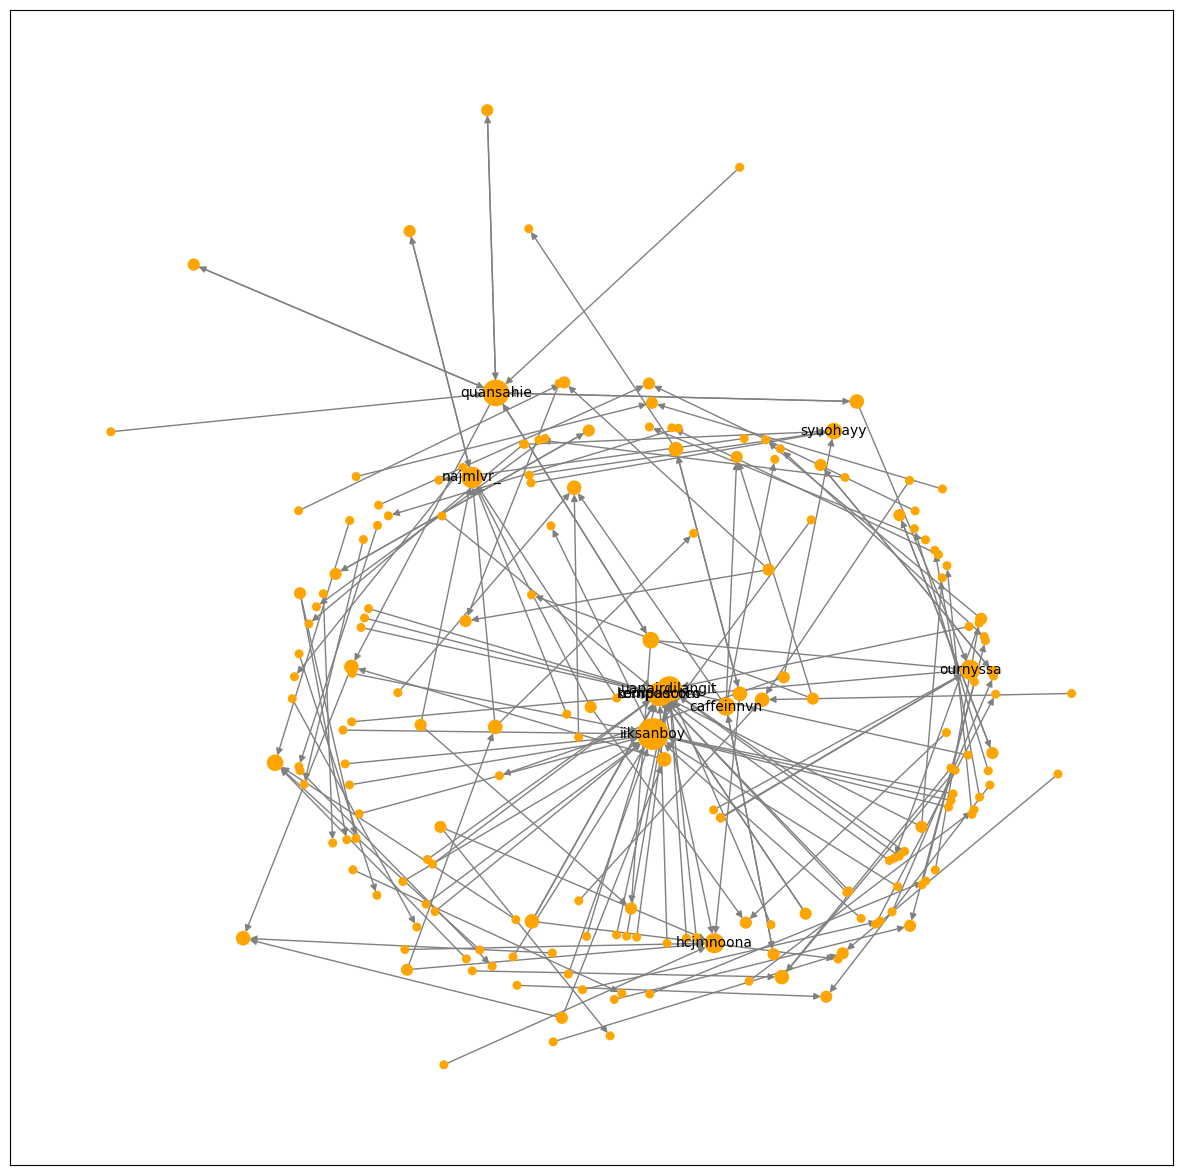

In [26]:
# Membuat visualisasi graph menggunakan metode Kamada Kawai
G = nx.from_pandas_edgelist(inset, source='user', target='mentioned', create_using=nx.DiGraph())

degree_centrality = dict(G.degree())
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(G, scale=2)
nx.draw_networkx(G,
                 with_labels=True,
                 labels={node: node if node in top_nodes else "" for node in G.nodes()},
                 node_color='orange',
                 edge_color='grey',
                 linewidths=1,
                 font_size=10,
                 node_size=[v * 30 for v in dict(G.degree()).values()],
                 pos=pos
                 )
plt.show()


Gambar diatas merupakan hasil visualisasi graph menggunakan metode kamada kawai. Metode Kamada Kawai adalah salah satu metode yang digunakan untuk visualisasi graf dengan menggunakan konsep gaya tarik dan tolak antara simpul-simpul yang terhubung atau tidak terhubung. Metode ini bertujuan untuk mencari posisi simpul-simpul yang meminimalkan fungsi energi yang ditentukan oleh jarak antara simpul-simpul dan panjang ideal dari sisi-sisi. Metode ini dapat menghasilkan visualisasi graf yang rapi, simetris, dan mudah dibaca.

In [27]:
# Menampilkan jumlah node dan edge dari graph
print("Nodes: {}".format(G.number_of_nodes()))
print("Edges: {}".format(G.number_of_edges()))

Nodes: 197
Edges: 165


## Centrality

## 3. Multi-Dimensional Centrality Analysis

Analisis ini menggunakan 6 metrik sentralitas berbeda untuk membedah peran setiap akun dalam jaringan **#PeringatanDarurat** dari tiga dimensi berbeda: **Jangkauan**, **Efisiensi**, dan **Kualitas**.

### Dimensi 1: Reach & Visibility (Jangkauan)
* **Degree Centrality:** Mengukur popularitas langsung. Akun dengan nilai ini adalah yang paling "berisik" atau aktif merespons.

### Dimensi 2: Efficiency & Control (Efisiensi Arus Informasi)
* **Closeness Centrality (The "Broadcaster"):** Mengukur kecepatan. Akun dengan skor tinggi dapat menyebarkan informasi ke seluruh jaringan dalam waktu paling singkat.
    * *Insight:* Ideal untuk menyebarkan pengumuman darurat agar cepat viral.
* **Betweenness Centrality (The "Gatekeeper"):** Mengukur kontrol. Akun yang menjadi jembatan antar kelompok. Tanpa mereka, informasi mungkin terhambat antar komunitas.

### Dimensi 3: Prestige & Quality Influence (Kualitas Pengaruh)
* **Eigenvector Centrality:** Menghitung pengaruh berdasarkan koneksi ke orang penting lainnya. "Bukan apa yang Anda tahu, tapi siapa yang Anda kenal."
* **PageRank:** Variasi dari Eigenvector yang dinormalisasi (algoritma Google). Lebih tahan terhadap manipulasi spam dibanding Degree.
* **Katz Centrality:** Mengukur pengaruh dengan mempertimbangkan tetangga langsung maupun tidak langsung, namun memberikan penalti untuk jarak yang jauh. Ini memberikan gambaran pengaruh global yang lebih halus.

### Degree Centrality

In [28]:
# Degree Centrality dengan menggunakan library
degree_centrality = nx.degree_centrality(G)
degree_centrality = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)
degree_centrality = pd.DataFrame(degree_centrality, columns=['user', 'degree_centrality'])
degree_centrality.head()

user  degree_centrality
0       iiksanboy           0.081633
1       quansahie           0.056122
2  uapairdilangit           0.051020
3      tempodotco           0.045918
4       kompascom           0.040816

In [29]:
# Degree centrality dengan tidak menggunakan library
degree_centrality = {}

def degree_function(G):
  s = 1 / (len(G) - 1)
  for n, d in G.degree():
      degree_centrality[n] = d * s
  return degree_centrality

degree_centrality = degree_function(G)

degree_centrality = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)
degree_centrality = pd.DataFrame(degree_centrality, columns=['user', 'degree_centrality'])
degree_centrality.head()

user  degree_centrality
0       iiksanboy           0.081633
1       quansahie           0.056122
2  uapairdilangit           0.051020
3      tempodotco           0.045918
4       kompascom           0.040816

### Closeness Centrality

In [30]:
# Closeness Centrality dengan menggunakan library
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality = sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)
closeness_centrality = pd.DataFrame(closeness_centrality, columns=['user', 'closeness_centrality'])
closeness_centrality.head()

user  closeness_centrality
0       iiksanboy              0.081633
1  uapairdilangit              0.051020
2      tempodotco              0.045918
3       kompascom              0.040816
4        najmlvr_              0.031250

In [31]:
# Closeness Centrality dengan tidak menggunakan library
closeness_centrality = {}

def closeness_function(G, source):
    seen = {}
    nextlevel = {source: 1}
    level = 0
    n = len(G)

    while nextlevel:
        thislevel = nextlevel
        nextlevel = {}
        for v in thislevel:
            if v not in seen:
                seen[v] = level
            for neighbor in G[v]:
                if neighbor not in seen:
                    nextlevel[neighbor] = 1
        level += 1

        if len(seen) == n:
            break
    return seen

for node in G.nodes():
    short_path = closeness_function(G, node)
    tot_short_path = sum(short_path.values())
    tot_node = len(G)
    closeness = 0

    if tot_short_path > 0 and tot_node > 1:
        closeness = (len(short_path) - 1) / (tot_node - 1)
        s = (len(short_path) - 1) / tot_short_path
        closeness *= s
    closeness_centrality[node] = closeness

closeness_centrality = sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)
closeness_centrality = pd.DataFrame(closeness_centrality, columns=['user', 'closeness_centrality'])
closeness_centrality.head()

user  closeness_centrality
0   quansahie              0.029685
1     aecocoo              0.023324
2  hellolanaa              0.020663
3    noctilix              0.020663
4  caffeinnvn              0.020408

Penjelasan program diatas adalah, fungsi closeness_function menggunakan algoritma BFS untuk menemukan jarak terpendek dari source ke semua node lainnya. Fungsi ini mengembalikan sebuah dictionary yang berisi node sebagai key dan jarak sebagai value.

Penjelasan variabel program diatas adalah:
1. G -> graph yang akan dihitung closeness centralitynya
2. source -> node yang akan dihitung closeness centralitynya
3. nextlevel -> dictionary yang digunakan untuk melacak node yang akan dikunjungi pada level berikutnya dalam pencarian BFS. nextlevel diisi dengan tetangga dari node yang sedang dikunjungi yang belum pernah dikunjungi sebelumnya
4. level -> variabel untuk melacak kedalaman saat ini dalam BFS. Setiap kali BFS pindah ke level berikutnya, variabel ini akan bertambah 1
5. seen -> dictionary yang digunakan untuk menyimpan node yang sudah dikunjungi dalam pencarian BFS

### Betweness Centrality

In [32]:
# Betweenness Centrality dengan menggunakan library
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)
betweenness_centrality = pd.DataFrame(betweenness_centrality, columns=['user', 'betweenness_centrality'])
betweenness_centrality.head()

user  betweenness_centrality
0   quansahie                0.001073
1     aecocoo                0.000222
2   arteisaxu                0.000209
3    najmlvr_                0.000157
4  caffeinnvn                0.000078

In [33]:
# Betweenness Centrality dengan tidak menggunakan library
betweenness_centrality = {}

def betweenness_function(G, s):
    P = {v: [] for v in G.nodes()}
    sigma = {v: 0 for v in G.nodes()}
    delta = {v: 0 for v in G.nodes()}
    D = {v: 0 for v in G.nodes()}

    S = []
    sigma[s] = 1
    D[s] = 1
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        Dv = D[v]
        sigmav = sigma[v]

        for w in G[v]:
            if D[w] == Dv + 1:
                sigma[w] += sigmav
                P[w].append(v)
            if D[w] == 0:
                Q.append(w)
                D[w] = Dv + 1
                sigma[w] += sigmav
                P[w].append(v)

    for w in reversed(S):
        coeff = (1 + delta[w]) / sigma[w]
        for v in P[w]:
            delta[v] += sigma[v] * coeff
        if w != s:
            betweenness_centrality[w] += delta[w]

for v in G.nodes:
    betweenness_centrality[v] = 0

for s in G.nodes:
    betweenness_function(G, s)

# Proses normalisasi
if len(G) > 2:
    scale = 1 / ((len(G) - 1) * (len(G) - 2))
    for v in betweenness_centrality:
        betweenness_centrality[v] *= scale

betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)
betweenness_centrality = pd.DataFrame(betweenness_centrality, columns=['user', 'betweenness_centrality'])
betweenness_centrality.head()

user  betweenness_centrality
0   quansahie                0.001073
1     aecocoo                0.000222
2   arteisaxu                0.000209
3    najmlvr_                0.000157
4  caffeinnvn                0.000078

Penjelasan program diatas adalah, fungsi betweenness_function menggunakan algoritma Brandes untuk menghitung betweenness centrality dari setiap node dalam graph.

Penjelasan variabel program diatas adalah:
1. P -> dictionary yang berisi node sebagai key dan daftar node pendahulu sebagai value. Node pendahulu adalah node yang berada pada jalur terpendek dari source ke node yang sedang lain.
2. sigma -> dictionary yang berisi node sebagai kunci dan jumlah jalur terpendek dari s ke node tersebut sebagai nilai.
3. delta -> dictionary yang berisi node sebagai kunci dan akumulasi kontribusi betweenness dari node tersebut sebagai nilai.
4. D -> dictionary yang berisi node sebagai kunci dan kedalaman atau jarak dari s ke node tersebut sebagai nilai.
5. S -> list yang berisi node yang sudah dikunjungi dalam urutan penelusuran
6. Q -> deque (double-ended queue) yang berisi node yang akan dikunjungi dalam pencarian breadth-first search (BFS).

### Eigenvector Centrality

In [34]:
# Eigenvector Centrality dengan menggunakan library
eigen_centrality = nx.eigenvector_centrality(G)
eigen_centrality = sorted(eigen_centrality.items(), key=lambda x:x[1], reverse=True)
eigen_centrality = pd.DataFrame(eigen_centrality, columns=['user', 'eigen_centrality'])
eigen_centrality.head()

user  eigen_centrality
0       quansahie          0.617213
1       arteisaxu          0.308607
2        ournyssa          0.308607
3         aecocoo          0.308607
4  plentyofjisung          0.308607

In [35]:
# Eigenvector Centrality dengan tidak menggunakan library

# def adjacency_matrix(G):
#     """Membuat matriks adjacency dari graf G."""
#     n = len(G.nodes())
#     A = np.zeros((n, n))
#     node_index = {node: i for i, node in enumerate(G.nodes())}

#     for u in G.nodes():
#         for v in G[u]:
#             A[node_index[u], node_index[v]] = 1

#     return A

# def eigenvector_centrality(G, max_iter=1000, tol=1e-6):
#     """Menghitung Eigenvector Centrality tanpa menggunakan library."""
#     A = adjacency_matrix(G)
#     n = A.shape[0]

#     # Inisialisasi vektor eigenvector
#     x = np.ones(n)

#     for _ in range(max_iter):
#         x_new = A @ x  # Mengalikan matriks adjacency dengan vektor
#         x_new = x_new / np.linalg.norm(x_new)  # Normalisasi

#         # Cek konvergensi
#         if np.linalg.norm(x_new - x) < tol:
#             break
#         x = x_new

#     # Normalisasi hasil
#     eigen_centrality = x / np.sum(x)  # Normalisasi agar jumlahnya 1

#     # Mengembalikan hasil dalam format DataFrame
#     eigen_centrality = sorted(zip(G.nodes(), eigen_centrality), key=lambda x: x[1], reverse=True)
#     eigen_centrality = pd.DataFrame(eigen_centrality, columns=['user', 'eigen_centrality'])

#     return eigen_centrality

# # Menghitung Eigenvector Centrality
# eigen_centrality_df = eigenvector_centrality(G)
# eigen_centrality_df.head()


def adjacency_matrix(G):
    """Membuat matriks adjacency dari graf G tanpa mengubah nama user."""
    nodes = list(G.nodes())  # Mengambil daftar nama user
    n = len(nodes)
    A = np.zeros((n, n))
    node_index = {node: i for i, node in enumerate(nodes)}

    for u in G.nodes():
        for v in G[u]:
            A[node_index[u], node_index[v]] = 1
            A[node_index[v], node_index[u]] = 1  # Jika graf tidak berarah

    return A, node_index, nodes

def eigenvector_centrality(G, max_iter=1000, tol=1e-6):
    """Menghitung Eigenvector Centrality tanpa library menggunakan power iteration."""
    A, node_index, nodes = adjacency_matrix(G)
    n = len(nodes)

    # Inisialisasi vektor eigen dengan nilai acak kecil
    x = np.random.rand(n)
    x /= np.linalg.norm(x)  # Normalisasi awal

    for _ in range(max_iter):
        x_new = np.dot(A, x)  # Perkalian matriks adjacency dengan vektor
        x_new /= np.linalg.norm(x_new, ord=2)  # Normalisasi dengan norma L2

        # Cek konvergensi
        if np.linalg.norm(x_new - x, ord=1) < tol:
            break
        x = x_new

    # Konversi hasil ke dictionary dengan nama user asli
    eigen_centrality = {nodes[i]: x[i] for i in range(n)}

    # Konversi ke DataFrame
    eigen_centrality = sorted(eigen_centrality.items(), key=lambda item: item[1], reverse=True)
    eigen_centrality_df = pd.DataFrame(eigen_centrality, columns=['user', 'eigen_centrality'])

    return eigen_centrality_df

# Menghitung Eigenvector Centrality tanpa library
eigen_centrality_df = eigenvector_centrality(G)
eigen_centrality_df.head()

user  eigen_centrality
0        iiksanboy          0.582088
1  Tonyjonatan1971          0.203281
2       chansholl_          0.203281
3          yeanjj_          0.203281
4        lofssenju          0.203281

### Katz Centrality

In [36]:
# Katz Centrality dengan menggunakan library
katz_centrality = nx.katz_centrality(G)
katz_centrality = sorted(katz_centrality.items(), key=lambda x:x[1], reverse=True)
katz_centrality = pd.DataFrame(katz_centrality, columns=['user', 'katz_centrality'])
katz_centrality.head()

user  katz_centrality
0       iiksanboy         0.167822
1  uapairdilangit         0.129094
2      tempodotco         0.122639
3       kompascom         0.116185
4       quansahie         0.107578

In [37]:
# Katz Centrality dengan tidak menggunakan library
def adjacency_matrix(G):
    """Membuat matriks adjacency dari graf G."""
    n = len(G.nodes())
    A = np.zeros((n, n))
    node_index = {node: i for i, node in enumerate(G.nodes())}

    for u in G.nodes():
        for v in G[u]:
            A[node_index[u], node_index[v]] = 1  # Untuk graf tidak terarah, tambahkan juga sebaliknya
            A[node_index[v], node_index[u]] = 1  # Menambahkan edge sebaliknya

    return A

def katz(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6):
    """Menghitung Katz Centrality tanpa menggunakan library."""
    A = adjacency_matrix(G)
    n = A.shape[0]

    # Inisialisasi vektor centrality
    x = np.ones(n) * beta  # Menggunakan beta sebagai nilai awal

    for _ in range(max_iter):
        x_new = beta + alpha * A @ x  # Menghitung nilai baru
        x_new = x_new / np.linalg.norm(x_new)  # Normalisasi

        # Cek konvergensi
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    # Mengembalikan hasil dalam format DataFrame
    katz = sorted(zip(G.nodes(), x), key=lambda x: x[1], reverse=True)
    katz_df = pd.DataFrame(katz, columns=['user', 'katz'])

    return katz_df

# Menghitung Katz Centrality secara manual
katz_df = katz(G)

# Menampilkan head dari hasil yang telah terurut
katz_df.head()

user      katz
0       iiksanboy  0.078444
1  uapairdilangit  0.075442
2      tempodotco  0.074956
3       kompascom  0.074453
4       quansahie  0.073960

### Pagerank Centrality

In [38]:
# Pagerank Centrality dengan menggunakan library
pagerank_centrality = nx.pagerank(G)
pagerank_centrality = sorted(pagerank_centrality.items(), key=lambda x:x[1], reverse=True)
pagerank_centrality = pd.DataFrame(pagerank_centrality, columns=['user', 'pagerank_centrality'])
pagerank_centrality.head()

user  pagerank_centrality
0        najmlvr_             0.046701
1     onyour_pika             0.042339
2       iiksanboy             0.037856
3  uapairdilangit             0.024632
4       quansahie             0.022429

In [39]:
def adjacency_matrix(G):
    """Membuat matriks adjacency dari graf G."""
    n = len(G.nodes())
    A = np.zeros((n, n))
    node_index = {node: i for i, node in enumerate(G.nodes())}

    for u in G.nodes():
        for v in G[u]:
            A[node_index[u], node_index[v]] = 1  # Untuk graf tidak terarah, tambahkan juga sebaliknya
            A[node_index[v], node_index[u]] = 1  # Menambahkan edge sebaliknya

    return A

def pagerank(G, alpha=0.85, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None):
    """Menghitung PageRank Centrality tanpa menggunakan library."""
    A = adjacency_matrix(G)
    n = A.shape[0]

    # Inisialisasi vektor PageRank
    pr = np.ones(n) / n  # Inisialisasi dengan distribusi uniform

    for _ in range(max_iter):
        pr_new = np.zeros(n)
        for i in range(n):
            # Menghitung PageRank untuk node i
            for j in range(n):
                if A[j, i] > 0:  # Jika ada link dari j ke i
                    pr_new[i] += pr[j] / np.sum(A[j])  # Menambahkan kontribusi dari node j
            pr_new[i] = alpha * pr_new[i] + (1 - alpha) / n  # Menambahkan faktor teleportasi

        # Cek konvergensi
        if np.linalg.norm(pr_new - pr) < tol:
            break
        pr = pr_new

    # Mengembalikan hasil dalam format DataFrame
    pagerank_df = sorted(zip(G.nodes(), pr), key=lambda x: x[1], reverse=True)
    pagerank_df = pd.DataFrame(pagerank_df, columns=['user', 'pagerank'])

    return pagerank_df

# Menghitung PageRank secara manual
pagerank_df = pagerank(G)

# Menampilkan head dari hasil yang telah terurut
pagerank_df.head()

user  pagerank
0       iiksanboy  0.040061
1  uapairdilangit  0.026067
2      tempodotco  0.021157
3       kompascom  0.018989
4       quansahie  0.015149

## Hasil Analisis

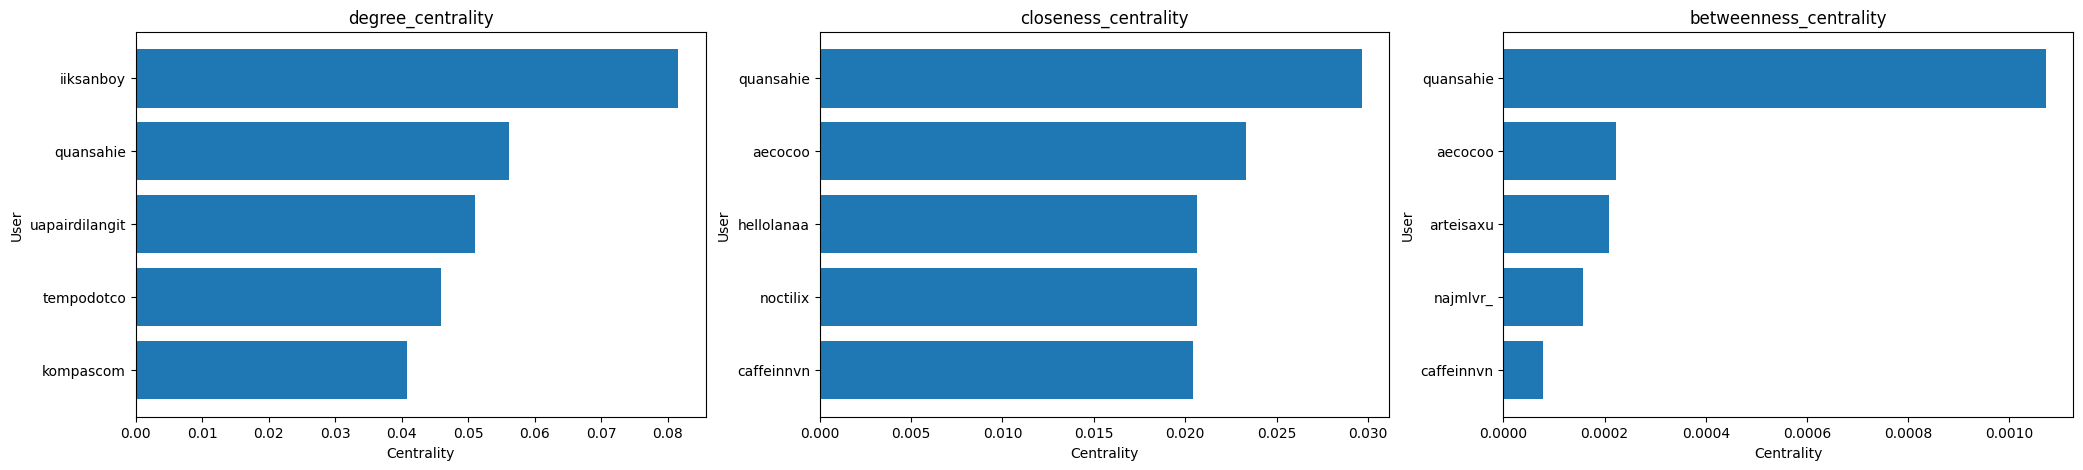

In [40]:
# Menampilkan visualisasi bar plot degree centrality, closeness centrality, dan betweenness centrality
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

centrality = [degree_centrality, closeness_centrality, betweenness_centrality]

for i, centrality in enumerate(centrality):
    centrality = centrality.head(5)
    ax[i].barh(centrality['user'], centrality.iloc[:, 1])
    ax[i].set_title(centrality.columns[1])
    ax[i].invert_yaxis()
    ax[i].set_xlabel('Centrality')
    ax[i].set_ylabel('User')

plt.show()

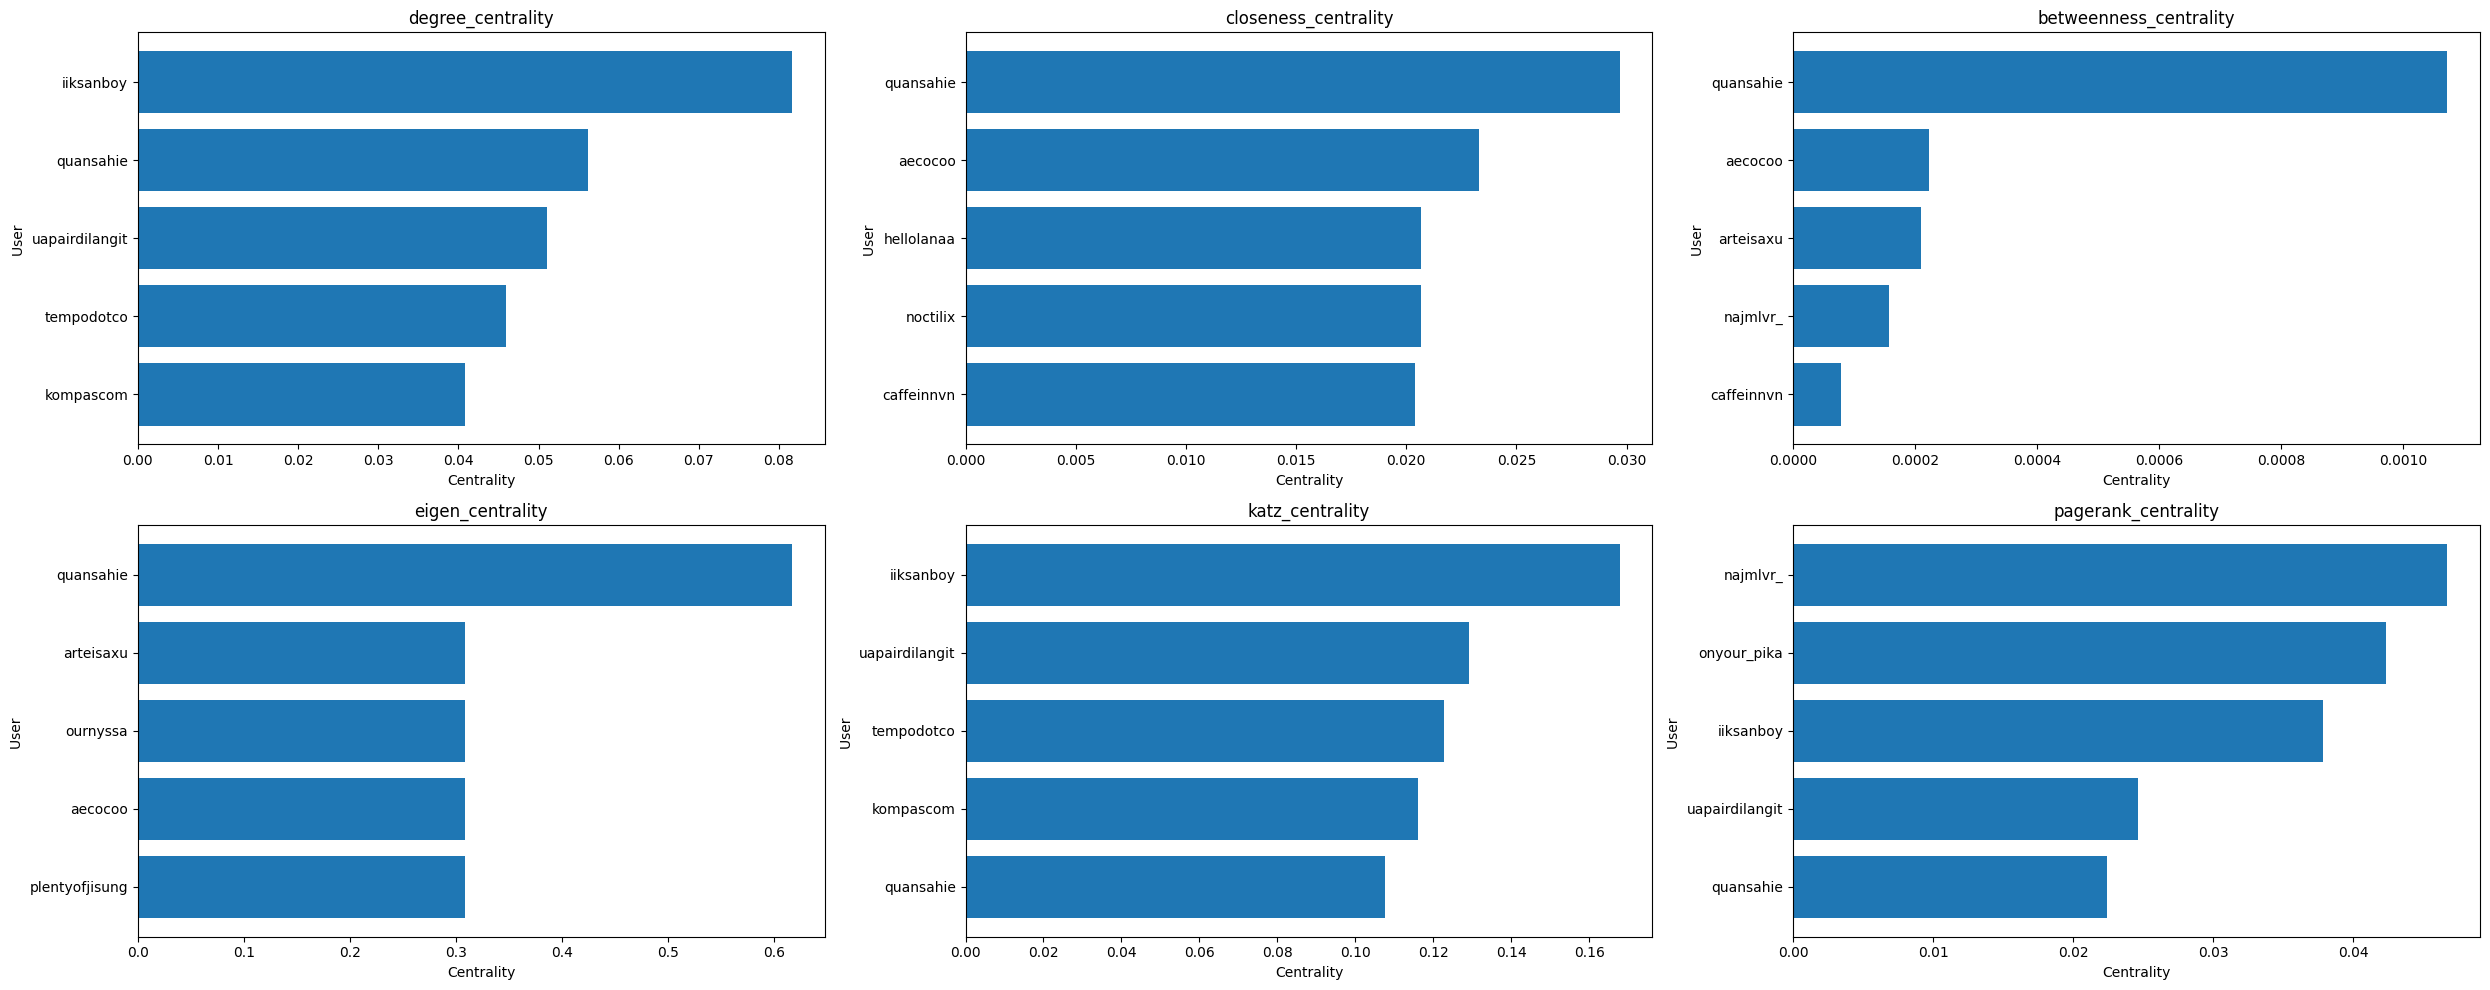

In [41]:
''' Menampilkan visualisasi bar plot degree centrality, closeness centrality,
betweenness centrality, eigenvector centrality, katz centrality, dan pagerank centrality'''
fig, ax = plt.subplots(2, 3, figsize=(25, 10))  # 2 baris dan 3 kolom

# Daftar centrality yang ingin ditampilkan
centrality_list = [
    degree_centrality,
    closeness_centrality,
    betweenness_centrality,
    eigen_centrality,
    katz_centrality,
    pagerank_centrality
]

for i, centrality in enumerate(centrality_list):
    centrality_top = centrality.head(5)
    row = i // 3  # Menentukan baris
    col = i % 3   # Menentukan kolom
    ax[row, col].barh(centrality_top['user'], centrality_top.iloc[:, 1])  # Menggunakan iloc untuk mengambil kolom kedua
    ax[row, col].set_title(centrality.columns[1])  # Judul berdasarkan nama kolom kedua
    ax[row, col].invert_yaxis()  # Membalik sumbu y
    ax[row, col].set_xlabel('Centrality')  # Label sumbu x
    ax[row, col].set_ylabel('User ')  # Label sumbu y

plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
plt.show()

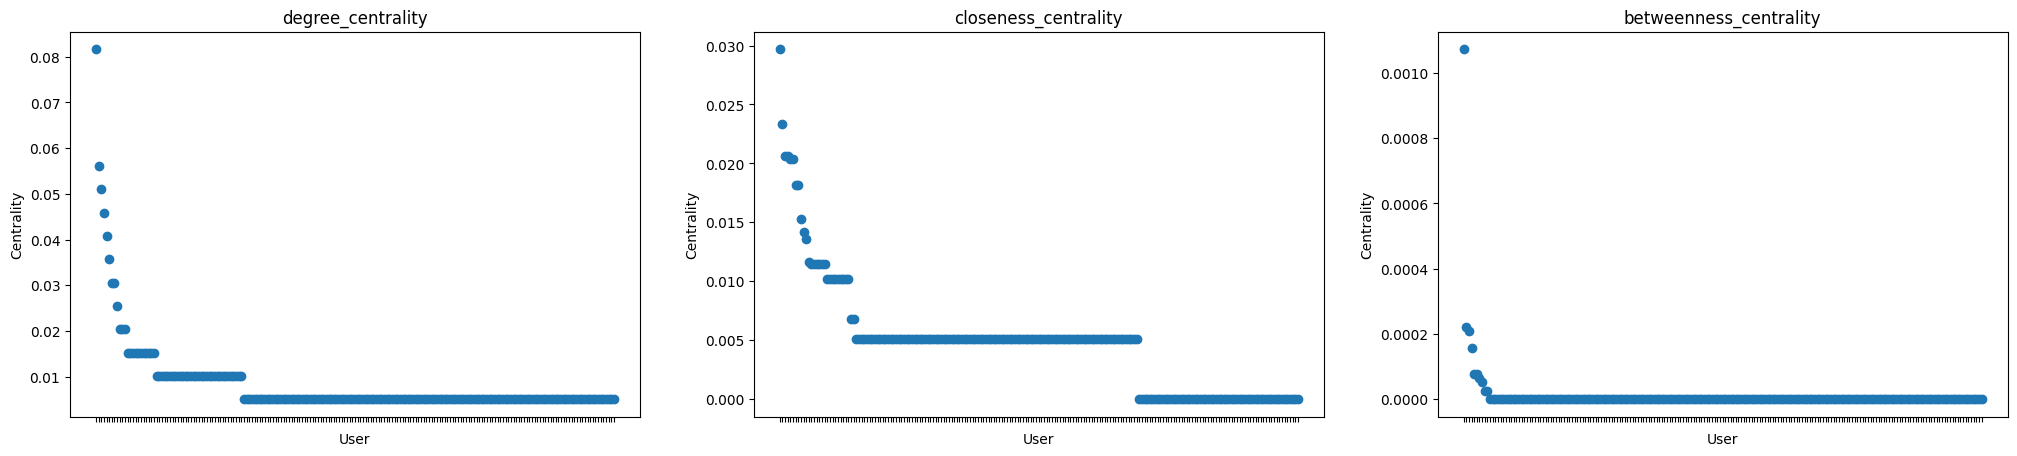

In [42]:
# Menampilkan visualisasi scatter plot degree centrality, closeness centrality, dan betweenness centrality
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

centrality = [degree_centrality, closeness_centrality, betweenness_centrality]

for i, centrality in enumerate(centrality):
    ax[i].scatter(centrality['user'], centrality.iloc[:, 1])
    ax[i].set_title(centrality.columns[1])
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('User')
    ax[i].set_ylabel('Centrality')

plt.show()

/tmp/ipython-input-2358133556.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[ax_row, ax_col].set_xticklabels(centrality['user'], rotation=45)  # Label sumbu x
/tmp/ipython-input-2358133556.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[ax_row, ax_col].set_xticklabels(centrality['user'], rotation=45)  # Label sumbu x
/tmp/ipython-input-2358133556.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[ax_row, ax_col].set_xticklabels(centrality['user'], rotation=45)  # Label sumbu x
/tmp/ipython-input-2358133556.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[ax_row, ax_col].set_xticklabels(centrality['user'], rotation=45)  # Label 

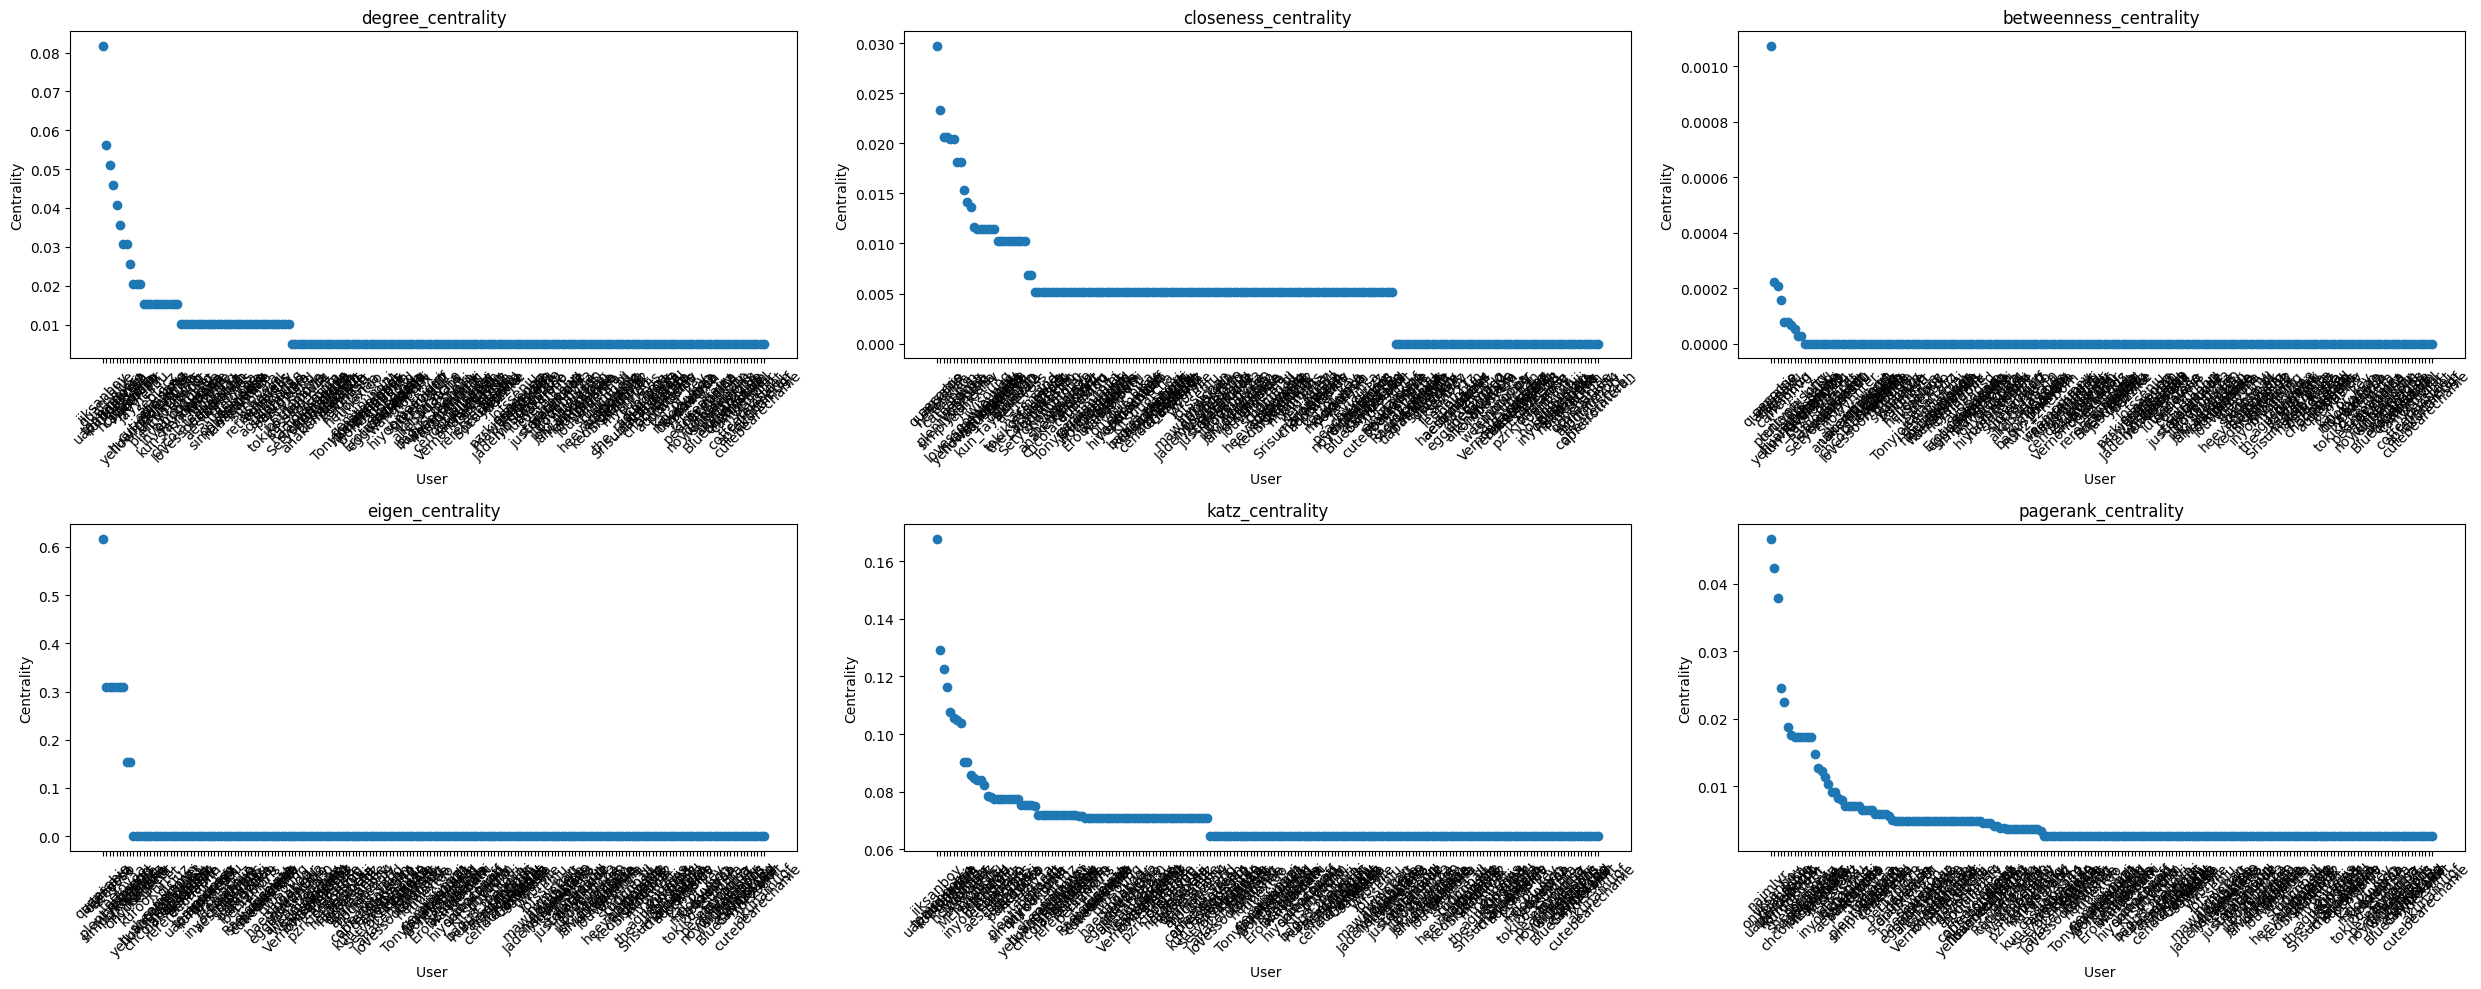

In [43]:
''' Menampilkan visualisasi scatter plot degree centrality, closeness centrality, betweenness centrality,
eigenvector centrality, katz centrality, dan pagerank centrality'''
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

centrality_list = [
    degree_centrality,
    closeness_centrality,
    betweenness_centrality,
    eigen_centrality,
    katz_centrality,
    pagerank_centrality
]

# Mengiterasi melalui centrality_list dan subplot
for i, centrality in enumerate(centrality_list):
    ax_row = i // 3  # Menentukan baris
    ax_col = i % 3   # Menentukan kolom
    ax[ax_row, ax_col].scatter(centrality['user'], centrality.iloc[:, 1])
    ax[ax_row, ax_col].set_title(centrality.columns[1])  # Judul berdasarkan nama kolom kedua
    ax[ax_row, ax_col].set_xticklabels(centrality['user'], rotation=45)  # Label sumbu x
    ax[ax_row, ax_col].set_xlabel('User ')  # Label sumbu x
    ax[ax_row, ax_col].set_ylabel('Centrality')  # Label sumbu y

plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
plt.show()

Berikut adalah analisis grafik dari setiap centrality:

- **Degree centrality**: Grafik ini menunjukkan jumlah hubungan yang dimiliki setiap user dengan user lain. User dengan degree centrality tinggi berarti memiliki banyak hubungan, sedangkan user dengan degree centrality rendah berarti memiliki sedikit hubungan.
- **Closeness centrality**: Grafik ini menunjukkan seberapa dekat setiap user dengan user lain dalam jaringan. User dengan closeness centrality tinggi berarti memiliki jarak yang kecil dengan user lain, sedangkan user dengan closeness centrality rendah berarti memiliki jarak yang besar dengan user lain.
- **Betweenness centrality**: Grafik ini menunjukkan seberapa sering setiap user berperan sebagai perantara atau penghubung antara user lain dalam jaringan. User dengan betweenness centrality tinggi berarti memiliki peran yang penting dalam menghubungkan user lain, sedangkan user dengan betweenness centrality rendah berarti memiliki peran yang kurang penting dalam menghubungkan user lain.

In [45]:
# Asumsi: G adalah graph object Anda
# Hitung semua centrality (pastikan library networkx sudah diimport sebagai nx)

print("Menghitung metrics... Mohon tunggu.")
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)
katz = nx.katz_centrality(G, alpha=0.01, beta=1.0) # Sesuaikan alpha jika perlu

# Gabungkan ke dalam DataFrame agar rapi
df_metrics = pd.DataFrame({
    'Degree': pd.Series(degree),
    'Closeness': pd.Series(closeness),
    'Betweenness': pd.Series(betweenness),
    'Eigenvector': pd.Series(eigenvector),
    'PageRank': pd.Series(pagerank),
    'Katz': pd.Series(katz)
})

# Urutkan berdasarkan PageRank (sebagai acuan utama kualitas) dan ambil Top 10
top_influencers = df_metrics.sort_values(by='PageRank', ascending=False).head(10)

# Tampilkan dengan gradasi warna agar cantik
print("--- Top 10 Influencers Multi-Dimensi ---")
display(top_influencers.style.background_gradient(cmap='YlOrRd'))

Menghitung metrics... Mohon tunggu.
--- Top 10 Influencers Multi-Dimensi ---


## 4. Strategic Insights & Conclusion

Berdasarkan analisis graf, ditemukan bahwa:
1.  **Aktor Utama:** Akun `Iksanboy, Quansahie` mendominasi percakapan dengan skor Degree tertinggi, mengindikasikan peran sebagai inisiator isu.
2.  **Pola Penyebaran:** Tersebar merata. Hal ini menunjukkan gerakan ini bersifat Organik .
3.  **Rekomendasi:** Untuk kampanye atau mitigasi isu serupa di masa depan, pendekatan tidak cukup hanya pada akun dengan follower besar, tetapi juga akun dengan **Betweenness Centrality** tinggi (`[Quansahie]`) karena mereka menjembatani berbagai komunitas audiens.